In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle

import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

### Data Acquisition

#### Create DataFrame

* Create dataframe with image_path, time(seconds) and speed

* In the video given, we have ~344 (5min 44s) seconds of video. 
* Our ground truth labels correspond to a video that is 12m 12s (~732seconds). 
* We only have a portion of that video. 
* It appears that our framerate <strong>~ 13 fps </strong>. (4459 frames * (1 second / 13frames) = 344 seconds)

In [2]:
df = pd.read_csv('./data/driving.csv')
df.head(10)
len(df)

4459

#### Plot Speeds vs Time

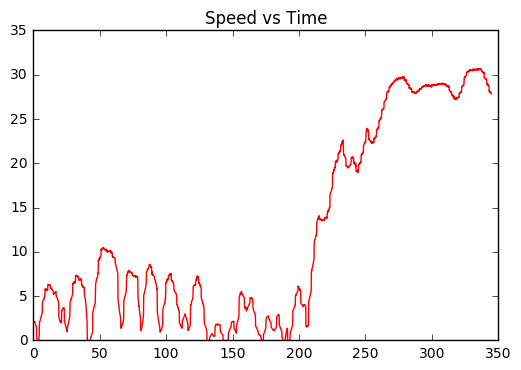

In [3]:
times = np.asarray(df['time'], dtype = np.float32)
speeds = np.asarray(df['speed'], dtype=np.float32)
plt.plot(times, speeds, 'r-')
plt.title('Speed vs Time')
plt.show()

In [4]:
df.tail(5)

,image_path,time,speed
4454,./data/IMG/344.3211498260498.jpg,344.321150,27.928958
4455,./data/IMG/344.37305998802185.jpg,344.373060,27.938640
4456,./data/IMG/344.5106108188629.jpg,344.510611,27.932405
4457,./data/IMG/344.5854048728943.jpg,344.585405,27.927574
4458,./data/IMG/344.63681387901306.jpg,344.636814,27.847842


### Shuffle Pairs and Train Test Split
* This function is a batch shuffler, 
* There is a 20% chance to add the row to validation data, other wise it will be train data

In [5]:
def batch_shuffle(dframe):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    for i in range(len(dframe) - 1):
        idx1 = np.random.randint(len(dframe) - 1)
        idx2 = idx1 + 1
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data


In [6]:
train_data, valid_data = batch_shuffle(df)

In [7]:
print('valid_data: ', len(valid_data))
print('train_data: ', len(train_data))

valid_datA:  1884
train_data:  7032


In [8]:
train_data.head(5)

,index,image_path,time,speed
0,2432,./data/IMG/177.80975079536438.jpg,177.809751,2.379161
0,2433,./data/IMG/177.88419198989868.jpg,177.884192,2.333900
0,2250,./data/IMG/163.70314693450928.jpg,163.703147,4.790292
0,2251,./data/IMG/163.7543079853058.jpg,163.754308,4.774892
0,3683,./data/IMG/277.07497692108154.jpg,277.074977,29.608331


## Preprocess

In [9]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

#### Perspective Transform

* I did not end up applying the perspective transform

In [10]:
def apply_perspective_transform(image):
    pass

In [11]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             2) Perspective transform
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    image_cropped = image[100:440, :-90] # -> (380, 550, 3)
    # TODO: Write perspective transform 
#     perspective = apply_perspective_transform(image_cropped)
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

In [12]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

In [13]:
def preprocess_image_from_path(image_path, speed, bright_factor):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = change_brightness(img, bright_factor)

            
    img = preprocess_image(img)
    return img, speed

### Generators

#### Train Generator
* This is used to yield train batches of image_difference and average speed. 
* We pick a random spot in the training dataset, between 1 and length - 1
* determine the relationship between 3 frames
* locate the current_frame and the next_frame
* Take the difference between them and their average speed and build batches with that information
* Then shuffle the batch and yield it, which will then be fed into the network
* Generators allow me to not clog my memory stack so I can perform these operations on 16 (`BATCH` size) at a time

In [14]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, len(data) - 1)
            
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['time'].values[0]
            time_prev = row_prev['time'].values[0]
            time_next = row_next['time'].values[0]
            
            if time_now - time_prev > 0 and 0.0000001 < time_now - time_prev < 0.58: # 0.578111 is highest diff i have seen
                # in this case row_prev is x1 and row_now is x2
                row1 = row_prev
                row2 = row_now
                
            elif time_next - time_now > 0 and 0.0000001 < time_next - time_now < 0.58:
                # in this case row_now is x1 and row_next is x2
                row1 = row_now
                row2 = row_next
                
                # Use this to find outliers
            else:
                print('time_now is not next or prev: ', time_now)
                print('time_prev is :', time_prev)
                print('time_next is: ', time_next)
                
                print('\n diff: now  - prev \t', time_now - time_prev)
                print('\n diff: next - now: \t', time_next - time_now)
            
            
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor)
           
            # subtract image features
            x = x1 - x2
            
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = x
            label_batch[i] = y
            
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

#### Validation Generator
* This is used to yield validation image_difference and average speed. 
* We pick iterate through the validation data, determine the relationship between 3 frames, locate the current_frame and the next_frame. Take the difference between them and their average speed and feed that into the network

In [15]:
def generate_validation_data(data):
    while True:
        for idx in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['time'].values[0]
            time_prev = row_prev['time'].values[0]
            time_next = row_next['time'].values[0]
            
            if time_now - time_prev > 0 and 0.0000001 < time_now - time_prev < 0.58:
                # in this case row_prev is x1 and row_now is x2
                row1 = row_prev
                row2 = row_now
                
            elif time_next - time_now > 0 and 0.000001 < time_next - time_now < 0.58:
                # in this case row_now is x1 and row_next is x2
                row1 = row_now
                row2 = row_next
            
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
            
            img_diff = x1 - x2
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            yield img_diff, speed

### Nvidia Model

Architecture can be found [here](https://arxiv.org/pdf/1511.07289v1.pdf)

(-0.5, 719.5, 959.5, -0.5)

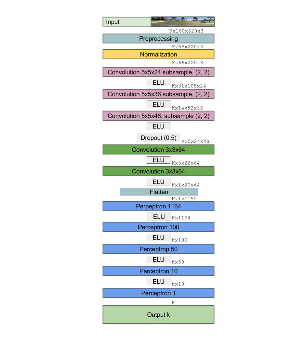

In [37]:
architecture = mpimg.imread('./data/Convnet Architecture Nvidia Model.jpg')
plt.imshow(architecture)
plt.axis('off')

In [16]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
tf.python.control_flow_ops = tf

N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv1'))
    
    model.add(ELU())    
    model.add(Convolution2D(36, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 3, 3, 
                            subsample = (1,1), 
                            border_mode = 'valid',
                            init = 'he_normal', #gaussian init
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, 3, 3, 
                            subsample= (1,1), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, init = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, init = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, init = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', init = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

Using TensorFlow backend.


#### Define training parameters

In [35]:
val_size = len(valid_data.index)
valid_generator = generate_validation_data(valid_data)
BATCH = 16
print('val_size: ', val_size)

val_size:  1884


#### Define model and train

In [ ]:
model = nvidia_model()
train_size = len(train_data.index)
for i in range(3):
    train_generator = generate_training_data(train_data, BATCH)
    history = model.fit_generator(
            train_generator, 
            samples_per_epoch = 20480, # try putting the whole thing in here in the future
            nb_epoch = 6,
            validation_data = valid_generator,
            nb_val_samples = val_size)
    print(history)
    
    model.save_weights('model-weights-F5.h5')
    model.save('model-F5.h5')

In [ ]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss 18 epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### Analysis
* With 6 epochs I noticed that I started to overfit my dataset when the validation loss started oscillating
* 5 loops 6 epochs: MSE (train):1.6149, MSE (valid): 20.3356
* 3 loops 6 epochs: MSE (train): , MSE (valid): 

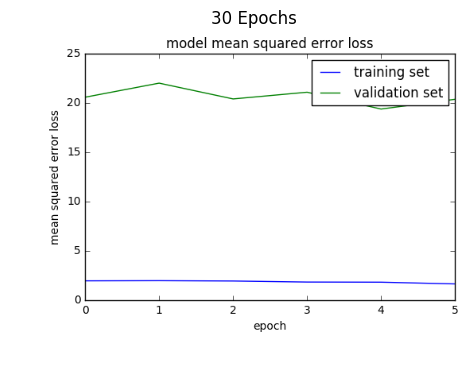

In [34]:
loop5epoch6 = mpimg.imread('./data/5Loops6EpochsDiag.png')
plt.imshow(loop5epoch6)
plt.axis('off')
plt.title('30 Epochs')

#### Train data preprocessing view

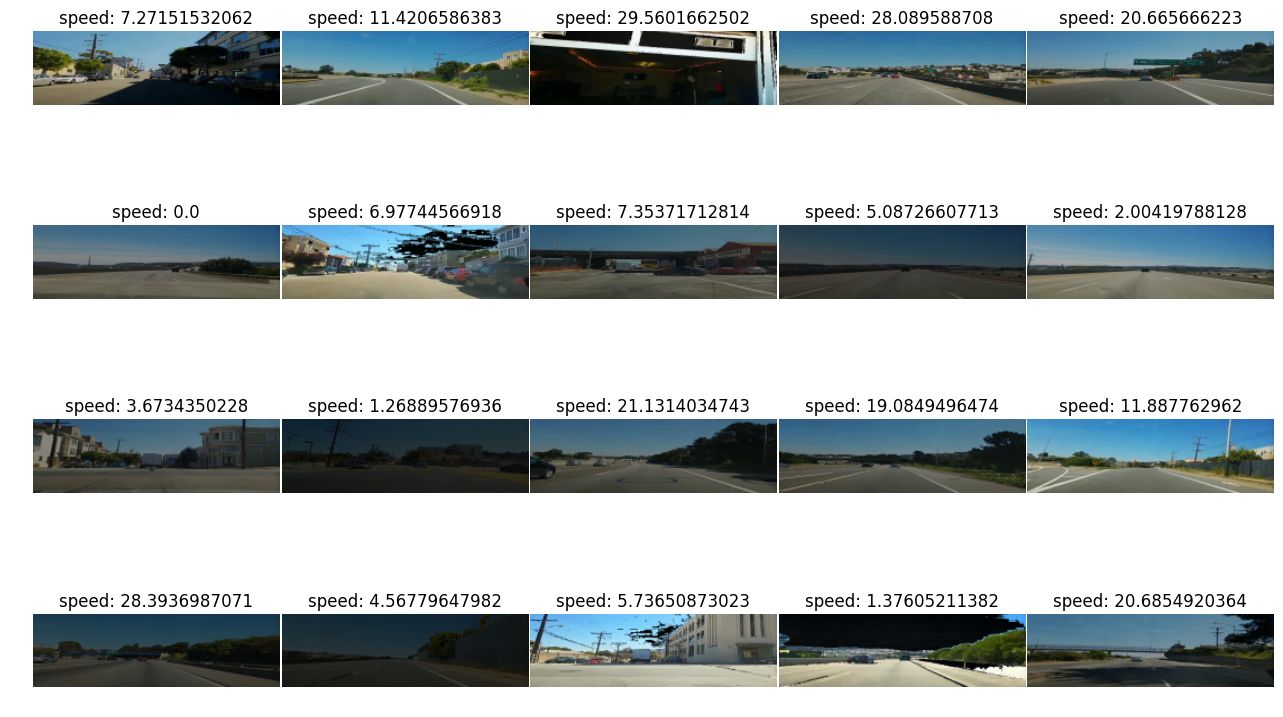

In [32]:
# random selection
data = train_data
random_images = []
for i in range(20):
    idx = np.random.randint(len(data))
    bright_factor = 0.2 + np.random.uniform()
    row = data.iloc[[idx]].reset_index()
    x, y = preprocess_image_from_path(row['image_path'].values[0], row['speed'].values[0], bright_factor)
    random_images.append((x, y))
    
plt.figure(figsize=(16, 10))
gs1 = gridspec.GridSpec(4, 5)
gs1.update(wspace = 0.01, hspace = 0.01)
for idx, image in enumerate(random_images):
    angle = 'speed: ' + str(image[1]) 
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.title(angle)
    plt.imshow(image[0])
plt.show()

#### Validation data preprocessing view

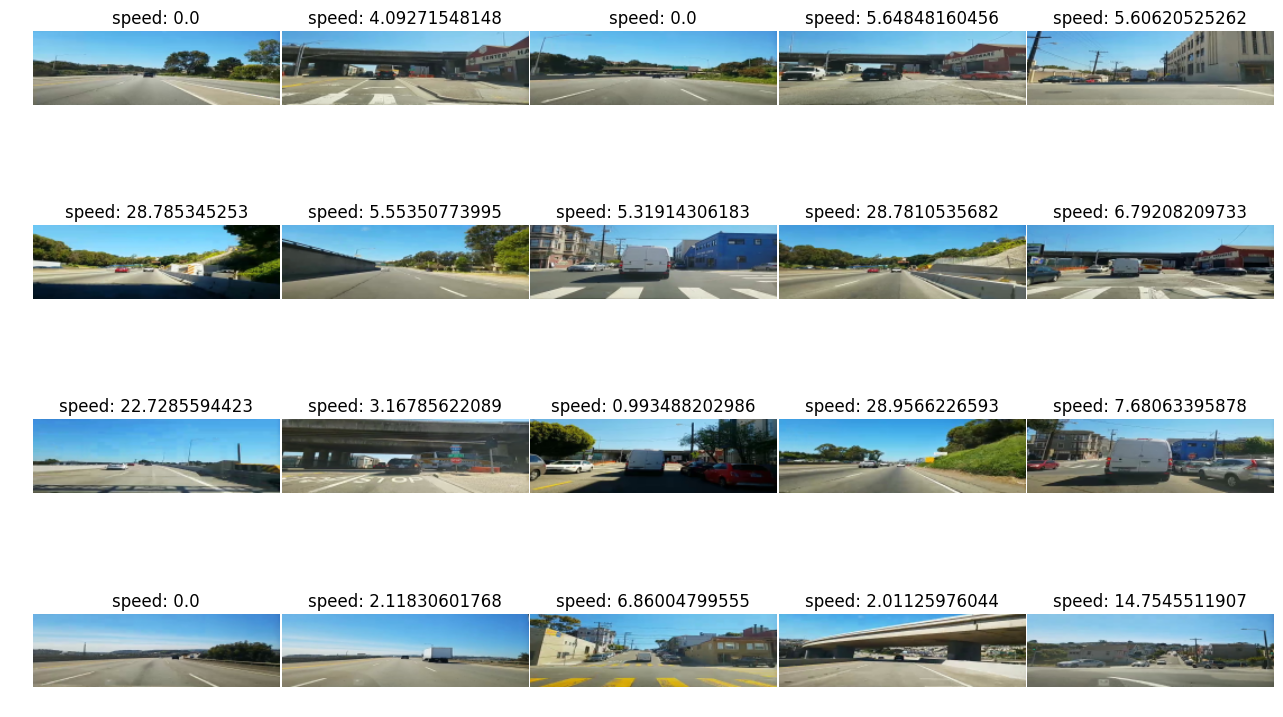

In [33]:
# random selection
data = train_data
random_images = []
for i in range(20):
    idx = np.random.randint(len(data))
    row = data.iloc[[idx]].reset_index()
    x, y = preprocess_image_valid_from_path(row['image_path'].values[0], row['speed'].values[0])
    random_images.append((x, y))
    
plt.figure(figsize=(16, 10))
gs1 = gridspec.GridSpec(4, 5)
gs1.update(wspace = 0.01, hspace = 0.01)
for idx, image in enumerate(random_images):
    angle = 'speed: ' + str(image[1]) 
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.title(angle)
    plt.imshow(image[0])
plt.show()

### IDEAS: 
* Run forwards (img1 - img2) mean(speed)
* Run backwards (img2 - img1) mean(speed)
* Compute speed differential then apply prediction as: current_speed += speed_difference
* speed_difference = xW + b

* Batch shuffler
* Apply perspective transform
* Sobely gradient 
* Gaussian blur

### Design considerations
* Originally I generated a new brightness factor for each image, but that created some disturbances when I wanted to take the difference between both images so instead I used the same brightness augmentation for the current_frame and the next_frame. It works both ways though, it may have been better to make a random brightness augmentation because at one instant if our frame is under clear lighting, and the next frame has a shadow, we would not know how to consider that pixel difference. 
* I used a generator and yielded batches of my results, I did this so I didn't clog my memory stack while training my model
* I took the input data and pushed the video images into a separate file and created a driving.csv file so I could use a pandas dataframe to read in each image path and only read in the image once I am in the generator. I could have just used moviepy and created a VideoFileClip and run all processing steps on each image, but I wouldn't have the same amount of control when testing out my preprocessing and data augmentation pipelines.

### Evaluate model performance
* I choose to evaluate my performance with this code block instead of using model.evaluate so I didn't clog my stack

In [18]:
samples = 1000
indices = [np.random.randint(1, 4430) for i in range(samples)]

In [19]:
errors = []
batch = []
labels = []
data = pd.read_csv('./data/driving.csv')
for idx in indices:
    row_now = data.iloc[[idx]].reset_index()
    row_prev = data.iloc[[idx - 1]].reset_index()
    row_next = data.iloc[[idx + 1]].reset_index()

    # Find the 3 respective times to determine frame order (current -> next)

    time_now = row_now['time'].values[0]
    time_prev = row_prev['time'].values[0]
    time_next = row_next['time'].values[0]

    if time_now - time_prev > 0 and 0.0000001 < time_now - time_prev < 0.58: # 0.578111 is highest diff i have seen
        # in this case row_prev is x1 and row_now is x2
        row1 = row_prev
        row2 = row_now

    elif time_next - time_now > 0 and 0.0000001 < time_next - time_now < 0.58:
        # in this case row_now is x1 and row_next is x2
        row1 = row_now
        row2 = row_next

    x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
    x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
    img_diff = x1 - x2
    img_diff_reshaped = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
    y = np.mean([y1, y2])
    batch.append(img_diff)
    labels.append(y)
    
print('done!')

done!


* Evaluate on subset

### Evaluate model performance
* Note we use mean y because that is what the model is estimating
* Ground truth y would be y2

### MSE for 18 epochs:

In [41]:
model = nvidia_model()
model.load_weights('model-weights-F5.h5')
print('::', model.evaluate(batch, labels, batch_size = 800))

1000/1000 [==============================] - 0s     
:: 23.2640167236


### MSE for 30 epochs:

In [23]:
model = nvidia_model()
model.load_weights('model-weights-F4.h5')
batch = np.asarray(batch)
labels = np.asarray(labels)
model.evaluate(batch, labels, batch_size = 800)

1000/1000 [==============================] - 0s     


19.802975654602051

Hopefully the 30 epoch model isn't overfitting

# <font color = "red">Test</font>

### Overlay prediction onto images and save to new directory

In [26]:
mkdir ./data/predict

### Overlay prediction onto images and save to new directory `predict`
* Note: This will use whatever `model` is in context

In [27]:
import os
# given an input image
 
data = pd.read_csv('./data/driving.csv')                    
for idx in range(1, len(data.index) - 1):
    row_now = data.iloc[[idx]].reset_index()
    row_prev = data.iloc[[idx - 1]].reset_index()
    row_next = data.iloc[[idx + 1]].reset_index()

    # Find the 3 respective times to determine frame order (current -> next)

    time_now = row_now['time'].values[0]
    time_prev = row_prev['time'].values[0]
    time_next = row_next['time'].values[0]

    if time_now - time_prev > 0 and 0.0000001 < time_now - time_prev < 0.58: # 0.578111 is highest diff i have seen
        # in this case row_prev is x1 and row_now is x2
        row1 = row_prev
        row2 = row_now

    elif time_next - time_now > 0 and 0.0000001 < time_next - time_now < 0.58:
        # in this case row_now is x1 and row_next is x2
        row1 = row_now
        row2 = row_next

    x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
    x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
    img_diff = x1 - x2
                                   
    # reshape image difference to feed into model.predict
    img_diff_reshaped = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
        
    # grab the mean speed y to check our model against
    y = np.mean([y1, y2])
                                   
    # note: y2 is the actual speed of the frame x2 which we will use for accurate prediction, even though
    # our model is based on x1 and x2
                                   
    # TODO: retrain model to evaluate y2 instead of mean(y1, y2) and check differences
                                   
    prediction = model.predict(img_diff_reshaped)
    error = abs(prediction - y2)
    truth = y2
                                       
    predict_path = os.path.join('./data/predict/', str(idx) + '.jpg')
                                   
    # overwrite the prediction of y2 onto image x2
    # save overwritten image x2 to new directory ./data/predict

                                   
    # Make a copy 
    x2_copy = np.copy(x2)
    
    # to write new image via openCV
    offset = 30
    font = cv2.FONT_HERSHEY_SIMPLEX
    x2_copy = cv2.resize(x2_copy, (640, 480), interpolation = cv2.INTER_AREA)
    cv2.putText(x2_copy,'pred: ' + str(prediction[0][0])[:5],(5,offset), font, 1,(0,0,0),1,cv2.LINE_AA)
    cv2.putText(x2_copy,'truth: ' + str(y2)[:5],(5,offset * 2), font, 1,(0,20,255),1,cv2.LINE_AA)
    cv2.putText(x2_copy, 'error: ' + str(error[0][0])[:5], (5, offset*3),font, 1, (255, 0, 0),1, cv2.LINE_AA)
    
    # convert back to BGR for writing
    x2_copy = cv2.cvtColor(x2_copy, cv2.COLOR_RGB2BGR)
    cv2.imwrite(predict_path, x2_copy)
    
print('done!')


done!


### Create video from sequence of images

In [28]:
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip
import glob
import os

images = ['./data/predict/' + str(i+1) + '.jpg' for i in range(0, 4457)]
clip = ImageSequenceClip(images, fps=13)
clip.write_videofile("movie.mp4", fps = 13)
print('done!')

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)262144/4830080 bytes (5.4%)655360/4830080 bytes (13.6%)1359872/4830080 bytes (28.2%)2392064/4830080 bytes (49.5%)3325952/4830080 bytes (68.9%)4464640/4830080 bytes (92.4%)4830080/4830080 bytes (100.0%)
  Done
File saved as /home/jj/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.
[MoviePy] >>>> Building video movie.mp4
[MoviePy] Writing video movie.mp4


100%|██████████| 4458/4458 [00:42<00:00, 104.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie.mp4 

done!


In [ ]:
# rm -rf ./data/predict/

In [30]:
from IPython.display import HTML

In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('movie.mp4'))

### Reflection
* Around 3 min into the video when we go onto the freeway the ground truth value is ~0 and the predicted value is ~0. I am quite unsure why this is.
* When we go onto the freeway again ~4min in it looks like it's doing a pretty good job of predicting the speed, except for the part where we drive into the garage, it is predicting ~27 mph but that can't be true. 

### Other Approaches
* I notices this article: (http://nicolovaligi.com/car-speed-estimation-windshield-camera.html#Giachetti1999) and this code: (https://gist.github.com/nicolov/d010233ea8d35887c6ab47cca97d396f) that uses Optical Flow to for Car Speed estimation using a single windshield camera. I copied the code, modified some fields so it worked with my dataset and ran it to see what happens.
* An interesting thing to note is that in this code he is using ground truth data to calibrate the `hf` factor. Still, once the car goes on the freeway and deals with speeds > 30mph it fails completely. 
I ran the code with my dataset, which you can see in <strong>OpticalFlow.ipynb </strong>, and here is the result I got.
* When I ran this code, I cropped out a ton of the image, meaning I lost a bunch of data. There are points when driving that the background and scenery can help define changes in velocity. Such as the difference in a trees position from one frame to the next, for this reason I went with the CNN approach.
* Next steps: My next step is to compute the optical flow for each (current_image, next_frame) and feed that into my network as well. This way I can have the best of both worlds. Stay tuned

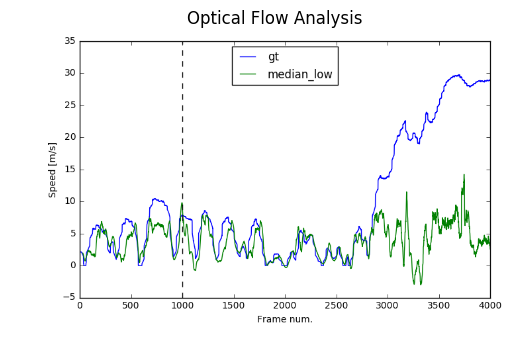

In [40]:
result = mpimg.imread('./data/optical_flow_result.png')
plt.imshow(result)
plt.axis('off')
plt.title('Optical Flow Analysis')

#### <font color = 'green'>Optical Flow</font> vs <font color = 'blue'>CNN</font> Analysis
* <font color = 'green'>3/4 in to the video, when we are absolutely on the freeway optical flow analysis tanks </font>
* <font color = 'blue'>In the CNN approach, we did pretty well 3/4ths into the video, I would say that the CNN's estimation was better than a pure optical flow approach, (assuming I did not overfit the dataset)</font>

### Future considerations
* If I had more time I would finish my DeepVO implementation [DeepVO](https://arxiv.org/pdf/1611.06069.pdf), which I started to write but did not finish. You can see DeepVO in <strong>DeepVO.ipynb</strong>
* I would also try to implement [DeepFlow](http://www.cv-foundation.org/openaccess/content_iccv_2013/papers/Weinzaepfel_DeepFlow_Large_Displacement_2013_ICCV_paper.pdf) which claims to have great performance. 
* I would also consider trying [FlowNet](https://arxiv.org/pdf/1504.06852.pdf) and I would use this as a [guide] (https://github.com/ClementPinard/FlowNetPytorch)